# Routing Heatmap for Small MoE Model

<a target="_blank" href="https://colab.research.google.com/github/simonguest/CS-394/blob/main/src/05/notebooks/moe-heatmap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://github.com/simonguest/CS-394/raw/refs/heads/main/src/05/notebooks/moe-heatmap.ipynb">
  <img src="https://img.shields.io/badge/Download_.ipynb-blue" alt="Download .ipynb"/>
</a>

## Install Dependencies

In [ ]:
!uv pip install -q --no-build-isolation transformers==4.57.6 torch flash_attn

## Load MoE Model

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-tiny-MoE-instruct",
    device_map="auto",
    dtype=torch.float16,
    trust_remote_code=True,
    output_router_logits=True  # Enable router outputs
)

tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/Phi-tiny-MoE-instruct",
    trust_remote_code=True
)

config.json: 0.00B [00:00, ?B/s]

configuration_slimmoe.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-tiny-MoE-instruct:
- configuration_slimmoe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_slimmoe.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-tiny-MoE-instruct:
- modeling_slimmoe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

## Register hooks and show routing for a few tokens in first layer

In [ ]:
PROMPT = "What is hello in Japanese?"

gate_layers = []
for name, module in model.named_modules():
    if 'block_sparse_moe.gate' in name:
        gate_layers.append((name, module))

print(f"Found {len(gate_layers)} gate layers\n")

router_outputs = []

def router_hook(module, input, output):
    router_outputs.append(output.detach().cpu())

# Register hooks
hooks = []
for name, module in gate_layers:
    hooks.append(module.register_forward_hook(router_hook))

inputs = tokenizer(PROMPT, return_tensors="pt").to(model.device)

# Run forward pass
router_outputs.clear()
with torch.no_grad():
    _ = model(**inputs, use_cache=False)

# Analyze first layer
router_probs = torch.softmax(router_outputs[0], dim=-1)
print("First layer routing:")
print(f"  Number of experts: {router_probs.shape[-1]}")
print(f"  Shape: {router_probs.shape}")

# Show top-k experts for first 5 tokens
for tok_idx in range(min(5, router_probs.shape[0])):
    top_k = torch.topk(router_probs[tok_idx], k=4)
    print(f"  Token {tok_idx}: top experts {top_k.indices.tolist()} "
          f"with probs {[f'{p:.3f}' for p in top_k.values.tolist()]}")

Found 32 gate layers


First layer routing:
  Number of experts: 16
  Shape: torch.Size([6, 16])
  Token 0: top experts [8, 11, 2, 15] with probs ['0.088', '0.078', '0.072', '0.071']
  Token 1: top experts [1, 15, 2, 6] with probs ['0.087', '0.085', '0.082', '0.078']
  Token 2: top experts [14, 3, 11, 4] with probs ['0.211', '0.081', '0.079', '0.072']
  Token 3: top experts [12, 2, 1, 15] with probs ['0.098', '0.082', '0.082', '0.081']
  Token 4: top experts [14, 5, 2, 10] with probs ['0.134', '0.068', '0.066', '0.063']


## Display routing heatmap

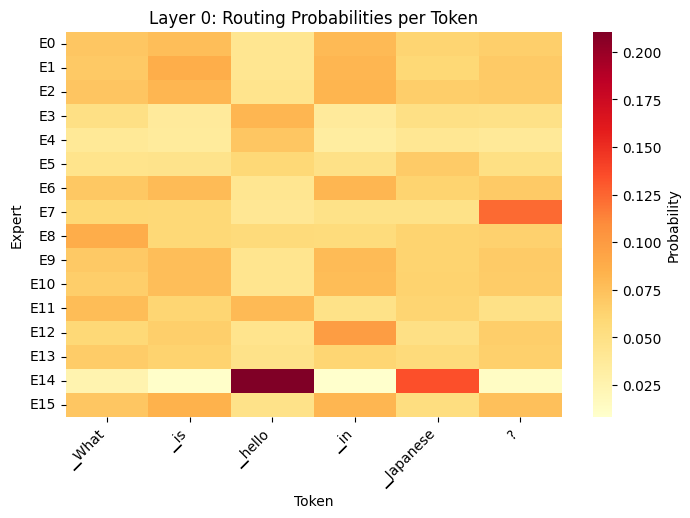

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

PROMPT = "What is hello in Japanese?"

def capture_routing(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    router_outputs.clear()
    with torch.no_grad():
        _ = model(**inputs, use_cache=False)

    return router_outputs[:32], tokens

def routing_heatmap(router_logits, tokens, layer_idx=0):
    # Get routing probabilities
    router_probs = torch.softmax(router_logits[layer_idx], dim=-1).numpy()
    num_tokens, num_experts = router_probs.shape

    fig, axes = plt.subplots(1, 1, figsize=(8, 5))

    # Use seaborn to display routing probabilities
    sns.heatmap(
        router_probs.T,
        cmap='YlOrRd',
        ax=axes,
        cbar_kws={'label': 'Probability'},
        xticklabels=tokens[:num_tokens],
        yticklabels=[f'E{i}' for i in range(num_experts)]
    )
    axes.set_title(f'Layer {layer_idx}: Routing Probabilities per Token')
    axes.set_xlabel('Token')
    axes.set_ylabel('Expert')
    plt.setp(axes.get_xticklabels(), rotation=45, ha='right')

outputs, tokens = capture_routing(PROMPT)

# Display heatmap for layer 0
routing_heatmap(outputs, tokens, layer_idx=0)


## Display routing heatmap for additional layers

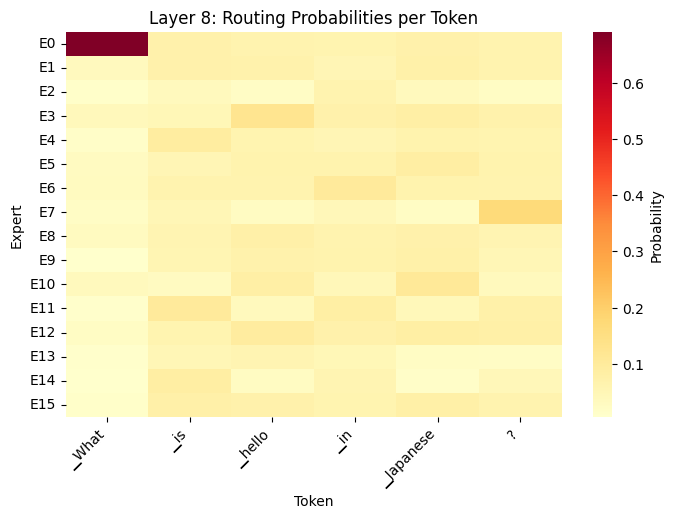

In [35]:
routing_heatmap(outputs, tokens, layer_idx=8)

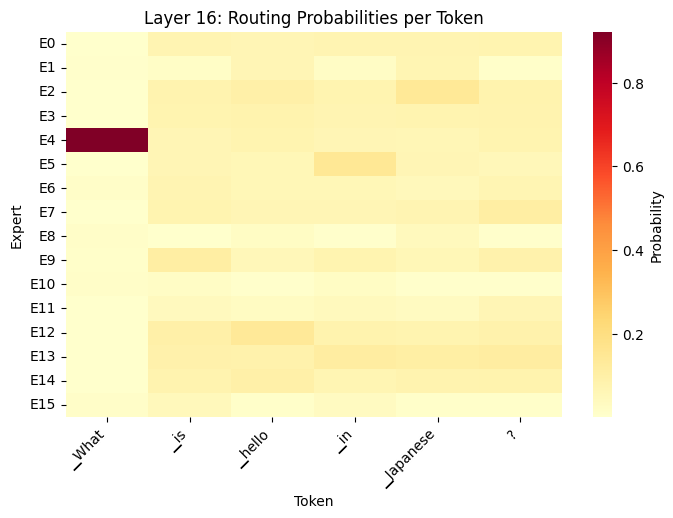

In [36]:
routing_heatmap(outputs, tokens, layer_idx=16)

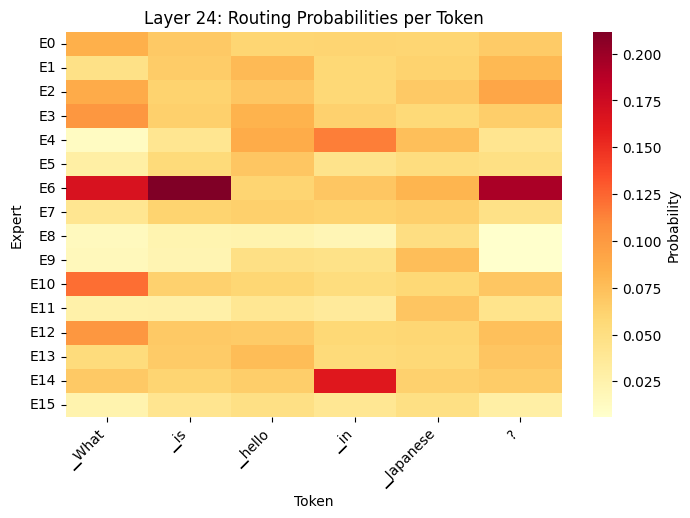

In [37]:
routing_heatmap(outputs, tokens, layer_idx=24)

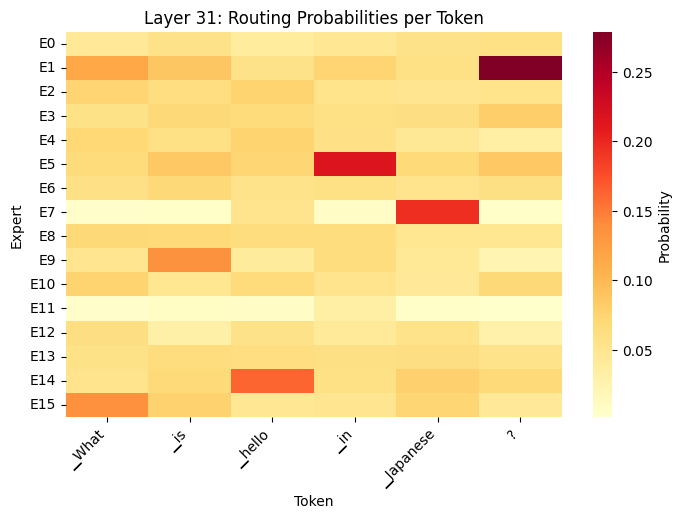

In [38]:
routing_heatmap(outputs, tokens, layer_idx=31)